In [7]:
import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import svgwrite
from IPython.display import SVG, display

X_SCALE = 0.15 # meters/pixel
Y_SCALE = 0.15 # meters/pixel

def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def read_image(image_path):
    return cv2.imread(image_path) # 1: BGR; 0: GRAY

def load_images_from_directory(directory):
    imgs = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(directory, filename)
            img = read_image(img_path)
            if img is not None:
                imgs.append((filename, img))
    return imgs

def create_samples_dict(samples, imgs):
    samples_dict = {}
    for sample in samples:
        token = sample['token']
        timestamp = sample['timestamp']
        scene_token = sample['scene_token']
        if scene_token not in samples_dict:
            samples_dict[scene_token] = []
        for filename, img in imgs:
            if token in filename:
                samples_dict[scene_token].append({'token': token, 'timestamp': timestamp, 'image': img, 'filename': filename})
    return samples_dict

def remove_white_areas(image):
    # 将图像转换为包含 alpha 通道的 RGBA 图像
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    
    # 创建一个 mask，找出指定颜色区域
    target_color = [245, 250, 249]  # BGR 格式
    color_mask = np.all(image[:, :, :3] == target_color, axis=-1)
    
    # 将指定颜色区域的 alpha 通道设为 0（透明）
    image[color_mask, 3] = 0
    
    return image

def process_samples_dict(samples_dict):
    for scene_token, items in samples_dict.items():
        for item in items:
            item['image'] = remove_white_areas(item['image'])
    return samples_dict

def fix_samples_data(data):
    # 遍历数据并修正 `prev` 和 `next` 字段
    for i in range(len(data)):
        if i == 0:
            data[i]['prev'] = ''
        else:
            current_timestamp = float(data[i]['timestamp'])
            previous_timestamp = float(data[i-1]['timestamp'])
            if current_timestamp == previous_timestamp + 0.5 and data[i]['scene_token'] == data[i-1]['scene_token']:
                data[i]['prev'] = data[i-1]['token']
            else:
                data[i]['prev'] = ''
                
    for i in range(len(data)):
        if i == len(data) - 1:
            data[i]['next'] = ''
        else:
            current_timestamp = float(data[i]['timestamp'])
            next_timestamp = float(data[i+1]['timestamp'])
            if next_timestamp == current_timestamp + 0.5 and data[i]['scene_token'] == data[i+1]['scene_token']:
                data[i]['next'] = data[i+1]['token']
            else:
                data[i]['next'] = ''
    
    return data

def display_image(image, title=''):
    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_svg(file_path):
    display(SVG(filename=file_path))

def find_closest_ego_pose(timestamp, ego_poses):
    timestamps = np.array([pose['timestamp'] for pose in ego_poses])
    closest_index = np.argmin(np.abs(timestamps - timestamp))
    return ego_poses[closest_index]

def transform_image(image, translation, rotation, x_scale, y_scale):
    # 将 translation 从米转换为像素
    x = int(translation[0] / x_scale)
    y = int(translation[1] / y_scale)
    
    # 将四元数转换为欧拉角
    r = R.from_quat(rotation)
    yaw = r.as_euler('zyx')[0]  # 只需要绕 z 轴的角度
    
    # 旋转图像
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -np.degrees(yaw)+90, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    
    return rotated_image, (x, y)

def get_info_from_ego_pose(ego_pose):
    translation = np.array(ego_pose['translation'])
    rotation = np.array(ego_pose['rotation'])
    velocity = np.array(ego_pose['velocity'])
    angular_velocity = np.array(ego_pose['angular_velocity'])
    acceleration = np.array(ego_pose['acceleration'])
    return translation, rotation, velocity, angular_velocity, acceleration

def calculate_displacement(velocity, acceleration, dt):
    # 使用简单的运动学公式 s = ut + 0.5at^2 计算位移
    displacement = velocity * dt + 0.5 * acceleration * (dt ** 2)
    return displacement

def stitch_images(samples_dict, ego_poses, x_scale, y_scale):
    # 假设场景地图的尺寸足够大，可以容纳所有局部地图
    scene_map = svgwrite.Drawing('scene_map.svg', profile='full')
    
    for scene_token, items in samples_dict.items():
        previous_timestamp = None
        previous_translation = None
        previous_velocity = None
        
        for item in items:
            timestamp = float(item['timestamp'])
            ego_pose = find_closest_ego_pose(timestamp, ego_poses)
            translation, rotation, velocity, angular_velocity, acceleration = get_info_from_ego_pose(ego_pose)
            
            if previous_timestamp is not None:
                dt = timestamp - previous_timestamp
                displacement = calculate_displacement(previous_velocity, acceleration, dt)
                
                # 更新 translation
                translation = previous_translation + displacement
            
            image = item['image']
            transformed_image, (x, y) = transform_image(image, translation, rotation, x_scale, y_scale)
            
            # 将 transformed_image 保存为临时文件
            temp_filename = f'temp_{item["filename"]}'
            cv2.imwrite(temp_filename, transformed_image)
            
            # 将图像引用添加到 SVG 中
            x_offset = x - transformed_image.shape[1] // 2
            y_offset = y - transformed_image.shape[0] // 2
            scene_map.add(scene_map.image(href=temp_filename, insert=(x_offset, y_offset), size=(transformed_image.shape[1], transformed_image.shape[0])))
            
            previous_timestamp = timestamp
            previous_translation = translation
            previous_velocity = velocity
    
    scene_map.save()
    return 'scene_map.svg'

if __name__ == "__main__":
    ego_poses_path = './dataset/MB_dataset2/egopose.json'
    samples_path = './dataset/MB_dataset2/mb_test/sample.json'
    segImg_dir = './segment_result/MB_dataset2/n005_E43proE7_wb_full'

    # 读取 JSON 文件
    ego_poses = read_json(ego_poses_path)['ego_poses']
    samples = fix_samples_data(read_json(samples_path))

    # 读取图像
    imgs = load_images_from_directory(segImg_dir)
    # 创建 samples_dict
    samples_dict = process_samples_dict(create_samples_dict(samples, imgs))

    # 拼接图像
    svg_file = stitch_images(samples_dict, ego_poses, X_SCALE, Y_SCALE)

    # 显示拼接好的场景地图
    display_svg(svg_file)

In [3]:
import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
import tqdm
from scipy.spatial.transform import Rotation as R

X_SCALE = 0.15 # meters/pixel 0.46875
Y_SCALE = 0.15 # meters/pixel 0.085227

def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def read_image(image_path):
    return cv2.imread(image_path) # 1: BGR; 0: GRAY

def load_images_from_directory(directory):
    imgs = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(directory, filename)
            img = read_image(img_path)
            if img is not None:
                imgs.append((filename, img))
    return imgs

def create_samples_dict(samples, imgs):
    samples_dict = {}
    for sample in samples:
        token = sample['token']
        timestamp = sample['timestamp']
        scene_token = sample['scene_token']
        if scene_token not in samples_dict:
            samples_dict[scene_token] = []
        for filename, img in imgs:
            if token in filename:
                samples_dict[scene_token].append({'token': token, 'timestamp': timestamp, 'image': img})
    return samples_dict

def remove_white_areas(image):
    # 将图像转换为包含 alpha 通道的 RGBA 图像
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    
    # 创建一个 mask，找出指定颜色区域
    target_color = [245, 250, 249]  # BGR 格式
    color_mask = np.all(image[:, :, :3] == target_color, axis=-1)
    
    # 将指定颜色区域的 alpha 通道设为 0（透明）
    image[color_mask, 3] = 0
    
    return image

def process_samples_dict(samples_dict):
    for scene_token, items in samples_dict.items():
        for item in items:
            item['image'] = remove_white_areas(item['image'])
    return samples_dict

def fix_samples_data(data):
    # 遍历数据并修正 `prev` 和 `next` 字段
    for i in range(len(data)):
        if i == 0:
            data[i]['prev'] = ''
        else:
            current_timestamp = float(data[i]['timestamp'])
            previous_timestamp = float(data[i-1]['timestamp'])
            if current_timestamp == previous_timestamp + 0.5 and data[i]['scene_token'] == data[i-1]['scene_token']:
                data[i]['prev'] = data[i-1]['token']
            else:
                data[i]['prev'] = ''
                
    for i in range(len(data)):
        if i == len(data) - 1:
            data[i]['next'] = ''
        else:
            current_timestamp = float(data[i]['timestamp'])
            next_timestamp = float(data[i+1]['timestamp'])
            if next_timestamp == current_timestamp + 0.5 and data[i]['scene_token'] == data[i+1]['scene_token']:
                data[i]['next'] = data[i+1]['token']
            else:
                data[i]['next'] = ''
    
    return data

def display_image(image, title='Image'):
    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def find_closest_ego_pose(timestamp, ego_poses):
    timestamps = np.array([pose['timestamp'] for pose in ego_poses])
    closest_index = np.argmin(np.abs(timestamps - timestamp))
    return ego_poses[closest_index]

def transform_image(image, translation, rotation, x_scale, y_scale):
    # 将 translation 从米转换为像素
    x = int(translation[0] / x_scale)
    y = int(translation[1] / y_scale)
    
    # 将四元数转换为欧拉角
    r = R.from_quat(rotation)
    yaw = r.as_euler('zyx')[0]  # 只需要绕 z 轴的角度
    
    # 旋转图像
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(yaw), 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    
    return rotated_image, (x, y)

def get_info_from_ego_pose(ego_pose):
    translation = ego_pose['translation']
    rotation = ego_pose['rotation']
    velocity = ego_pose['velocity']
    angular_velocity = ego_pose['angular_velocity']
    acceleration = ego_pose['acceleration']
    return translation, rotation, velocity, angular_velocity, acceleration

def stitch_images(samples_dict, ego_poses, x_scale, y_scale):
    # 假设场景地图的尺寸足够大，可以容纳所有局部地图
    scene_map = np.zeros((1000, 1000, 4), dtype=np.uint8)
    
    for scene_token, items in samples_dict.items():
        for item in items:
            timestamp = float(item['timestamp'])
            ego_pose = find_closest_ego_pose(timestamp, ego_poses)
            translation, rotation, velocity, angular_velocity, acceleration = get_info_from_ego_pose(ego_pose)
            
            image = item['image']
            transformed_image, (x, y) = transform_image(image, translation, rotation, x_scale, y_scale)
            
            # 将 transformed_image 放置到 scene_map 上的 (x, y) 位置
            x_offset = x - transformed_image.shape[1] // 2
            y_offset = y - transformed_image.shape[0] // 2
            
            for i in range(transformed_image.shape[0]):
                for j in range(transformed_image.shape[1]):
                    if transformed_image[i, j, 3] != 0:  # 只复制非透明部分
                        scene_map[y_offset + i, x_offset + j] = transformed_image[i, j]
    
    return scene_map

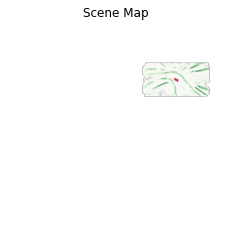

In [4]:
if __name__ == "__main__":
    ego_poses = './dataset/MB_dataset2/egopose.json'
    samples = './dataset/MB_dataset2/mb_test/sample.json'
    segImg_dir = './segment_result/MB_dataset2/n005_E43proE7_wb_full'

    # 读取 JSON 文件
    ego_poses = read_json(ego_poses)['ego_poses']
    samples = fix_samples_data(read_json(samples))

    # 读取图像
    imgs = load_images_from_directory(segImg_dir)
    # 创建 samples_dict
    samples_dict = process_samples_dict(create_samples_dict(samples, imgs))

    # 拼接图像
    scene_map = stitch_images(samples_dict, ego_poses, X_SCALE, Y_SCALE)

    # 显示拼接好的场景地图
    display_image(scene_map, title='Scene Map')


In [5]:
# 打印结果
for scene_token, items in samples_dict.items():
    print(f"Scene Token: {scene_token}, Number of Items: {len(items)}")
    for item in items:
        print(f"  Token: {item['token']}, Image Shape: {item['image'].shape}")

Scene Token: Sdics5PKfxaRKsQdNVAA1BWCLUT4Tmz1, Number of Items: 47
  Token: aTnAlVRCA2DMxiQnEBUmCSCquRwurKU4, Image Shape: (154, 308, 4)
  Token: DhIYqPEelY3JMPKTRZjn2efdDXcK4fWR, Image Shape: (154, 308, 4)
  Token: RyF2siau1RyBsduAOC2lNpJK76l7nwN0, Image Shape: (154, 308, 4)
  Token: HJgMGGllqpOXs7PCizV3AROaevuAAuZk, Image Shape: (154, 308, 4)
  Token: VLy4dh05gK69yTJfEJUqihtX2DNL9FS9, Image Shape: (154, 308, 4)
  Token: F3zaj9YGBdt6Ruqc9tgsYXzAtuBdkvB0, Image Shape: (154, 308, 4)
  Token: rl7oDx9zxKctmu4RWH0ndD5g76Aik0pw, Image Shape: (154, 308, 4)
  Token: Hsy0P5HrG5OXlPXQPwQc3h6122Hm3fuI, Image Shape: (154, 308, 4)
  Token: iC3HCyVlthqyLQVwojfCHOrPcHaimakh, Image Shape: (154, 308, 4)
  Token: S63RL8MuVMUO1dinQaXRPeSNjbONYRPa, Image Shape: (154, 308, 4)
  Token: yZVkh5LJ659C0tIyRITi7CWJlL9HEAQs, Image Shape: (154, 308, 4)
  Token: lgtXcg4nTtphScro97EeDt1Sz2wBJ5S4, Image Shape: (154, 308, 4)
  Token: 417J7qyqis2Iq0FU0tI4mOxoOb40jSpW, Image Shape: (154, 308, 4)
  Token: xwC2ehTH944Pcs

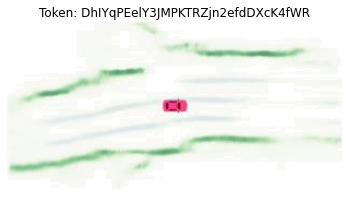

In [6]:
# 示例：调用并打印某个图像
target_scene_token = 'Sdics5PKfxaRKsQdNVAA1BWCLUT4Tmz1'
target_token = 'DhIYqPEelY3JMPKTRZjn2efdDXcK4fWR'

if target_scene_token in samples_dict:
    for item in samples_dict[target_scene_token]:
        if item['token'] == target_token:
            display_image(item['image'], title=f"Token: {target_token}")
            break
else:
    print(f"Scene Token {target_scene_token} not found.")